In [1]:
import gc
del variable_grande
gc.collect()


NameError: name 'variable_grande' is not defined

In [1]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt

import os
from PIL import Image

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.models import load_model

# Detection 7 emotions

The objective is to detect the emotion of a face with an image as input and an array as output with the probability that the image belongs to the different emotions : "angry", "disgusted", "fearful", "happy", "neutral", "sad" and "surprised".

In [5]:
# Get the current working directory

# Path
train_folder = "emotion_face_7/train/"
test_folder = "emotion_face_7/test/"

# Get the directory and list the files
cwd = os.getcwd()
files = os.listdir(cwd)

In [7]:
# Data augmentation, resize and normalization for the train and test dataset

# Data augmentation and normalization for the train dataset
train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=20,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0.1,
                                     zoom_range=0.1,
                                     horizontal_flip = True,
                                     fill_mode='nearest')
# Resize for the train dataset
train_generator = train_datagen.flow_from_directory(
        directory=train_folder,
        target_size=(48,48),
        batch_size=32,
        class_mode='categorical')

# Data normalization for the test dataset
test_datagen = ImageDataGenerator(rescale = 1./255)
# Resize for the test dataset
test_generator = test_datagen.flow_from_directory(
        directory=test_folder,
        target_size=(48,48),
        batch_size=32,
        class_mode='categorical')

# We have 28709 images in the train dataset and 7177 in the test dataset

Found 28709 images belonging to 7 classes.
Found 7177 images belonging to 7 classes.


In [ ]:
# Function to create our model and to see its architecture

def create_model():
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(128,(3,3),activation="relu",input_shape=(48,48,3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(128,(3,3),activation="relu"),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256,activation="relu"),
            tf.keras.layers.Dense(7,activation="softmax")
            ])
    return model

model = create_model()
model.summary()

In [ ]:
# Compile our model and fit with our train dataset

# Compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit
history = model.fit(train_generator,
                    steps_per_epoch=56,
                    epochs = 500,
                    validation_data=test_generator,
                    validation_steps = 56)

In [6]:
# Function to plot the history of the loss and the accuracy of our model

def plot_loss_acc(history_fit):
  acc = history_fit.history['accuracy']
  val_acc = history_fit.history['val_accuracy']
  loss = history_fit.history['loss']
  val_loss = history_fit.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
# Plot of the history of loss and accuracy during the epochs

plot_loss_acc(history)

In [30]:
# Save our model

#model.save('Model_7.h5')

In [2]:
# Load our model

#model=load_model('Model_7.h5')

In [92]:
# Function to group probabilities to compare positive, negative and neutral emotions.

def group_emotions(emotion_predictions):

    # Definitions of our new emotions
    neutral_emotions = ["neutral"]
    positive_emotions = ["happy", "surprised"]
    negative_emotions = ["angry", "disgusted", "fearful", "sad"]

    # Initialization of the scores
    neutral_score = 0
    positive_score = 0
    negative_score = 0

    # New scores
    for emotion, prediction in emotion_predictions:
        if emotion in neutral_emotions:
            neutral_score += prediction
        elif emotion in positive_emotions:
            positive_score += prediction
        elif emotion in negative_emotions:
            negative_score += prediction

    grouped_emotions = [("Neutral", f"{round(neutral_score*100, 2)}%"),
                        ("Positive", f"{round(positive_score*100, 2)}%"),
                        ("Negative", f"{round(negative_score*100, 2)}%")]

    # Sort our result
    sorted_grouped_emotions = sorted(grouped_emotions, key=lambda x: float(x[1][:-1]), reverse=True)

    return sorted_grouped_emotions


In [93]:
# Function to predict the emotion of an image

def seven_emotions(img_path, model):

    l_emotions = ["angry", "disgusted", "fearful", "happy", "neutral", "sad", "surprised"]

    # Take the image
    img_1 = Image.open(img_path)

    # Normalization
    img = np.asarray(img_1)/255.0

    # Resize
    img = cv2.resize(img, (48, 48))
    img = np.expand_dims(img, axis=0)

    # Prediction of the image

    predictions = model.predict(np.array(img))

    emotion_predictions = zip(l_emotions, predictions[0])
    sorted_predictions = sorted(emotion_predictions, key=lambda x: x[1], reverse=True)

    # Print the predictions and return the image
    for emotion, prediction in sorted_predictions:
        percentage = round(prediction * 100, 2)
        print(emotion, ":", f"{prediction:.2%}")

    print(group_emotions(sorted_predictions))

    return img_1

1/1 [==============================] - 0s 30ms/step
fearful : 29.46%
sad : 22.57%
angry : 18.95%
happy : 18.63%
neutral : 8.52%
surprised : 1.83%
disgusted : 0.03%
[('Negative', '71.02%'), ('Positive', '20.47%'), ('Neutral', '8.52%')]


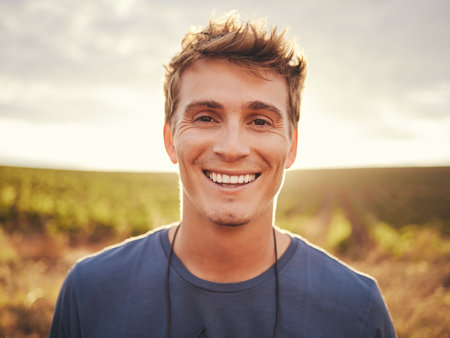

In [94]:
# Image 1

seven_emotions('happy.jpg', model)

1/1 [==============================] - 0s 31ms/step
neutral : 27.41%
happy : 26.23%
sad : 22.91%
fearful : 19.44%
angry : 3.05%
surprised : 0.87%
disgusted : 0.08%
[('Negative', '45.48%'), ('Neutral', '27.41%'), ('Positive', '27.1%')]


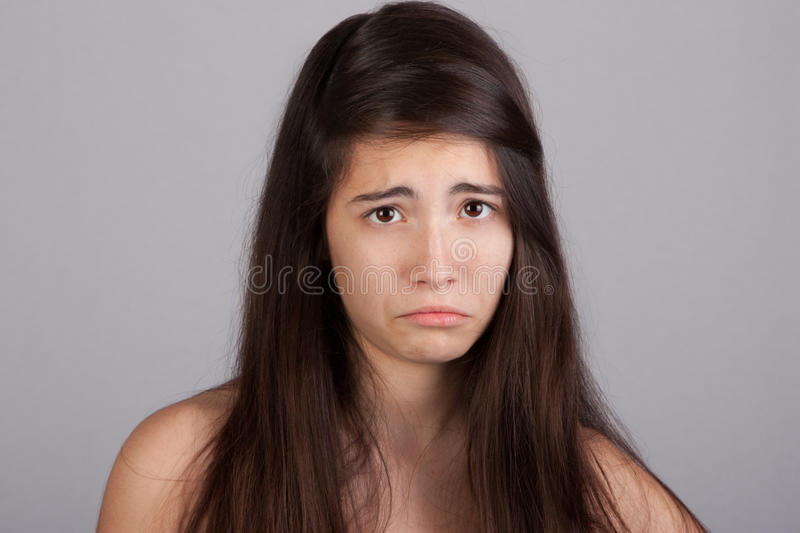

In [95]:
# Image 2

seven_emotions('sad.jpg', model)

In [ ]:
# Image 3

seven_emotions('julien_happy.jpg', model)

In [ ]:
# Image 4

seven_emotions('gab_happy.jpg', model)

In [ ]:
# Image 5

seven_emotions('noah_angry.jpg', model)

In [ ]:
# Image 6

seven_emotions('julien_neutre.jpg', model)

# Detection of 3 emotions

In [2]:
# Get the current working directory

# Path
train_folder = "emotion_face_3_soft/train/"
test_folder = "emotion_face_3_soft/test/"

# Get the directory and list the files
cwd = os.getcwd()
files = os.listdir(cwd)

In [3]:
# Data augmentation, resize and normalization for the train and test dataset

# Data augmentation and normalization for the train dataset
train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=20,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0.1,
                                     zoom_range=0.1,
                                     horizontal_flip = True,
                                     fill_mode='nearest')
# Resize for the train dataset
train_generator = train_datagen.flow_from_directory(
        directory=train_folder,
        target_size=(48,48),
        batch_size=32,
        class_mode='categorical',
        shuffle=True)

# Data normalization for the test dataset
test_datagen = ImageDataGenerator(rescale = 1./255)
# Resize for the test dataset
test_generator = test_datagen.flow_from_directory(
        directory=test_folder,
        target_size=(48,48),
        batch_size=32,
        class_mode='categorical',
        shuffle=True)

# We have 28709 images in the train dataset and 7177 in the test dataset

Found 12131 images belonging to 3 classes.
Found 3016 images belonging to 3 classes.


In [4]:
# Function to create our model and to see its architecture

def create_model():
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(128,(3,3),activation="relu",input_shape=(48,48,3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(128,(3,3),activation="relu"),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256,activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(128,activation="relu"),
            tf.keras.layers.Dense(3,activation="softmax")
            ])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 256)               3

In [5]:
# 3 _ soft _ 1000
# Compile our model and fit with our train dataset

# Compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit
history = model.fit(train_generator,
                    steps_per_epoch=56,
                    epochs = 1000,
                    validation_data=test_generator,
                    validation_steps = 56)

Epoch 1/1000
56/56 [==============================] - 27s 418ms/step - loss: 1.1070 - accuracy: 0.3590 - val_loss: 1.0990 - val_accuracy: 0.3421
Epoch 2/1000
56/56 [==============================] - 22s 389ms/step - loss: 1.0958 - accuracy: 0.3493 - val_loss: 1.0947 - val_accuracy: 0.3164
Epoch 3/1000
56/56 [==============================] - 16s 282ms/step - loss: 1.0872 - accuracy: 0.3929 - val_loss: 1.0863 - val_accuracy: 0.3583
Epoch 4/1000
56/56 [==============================] - 10s 185ms/step - loss: 1.0865 - accuracy: 0.3901 - val_loss: 1.0941 - val_accuracy: 0.3633
Epoch 5/1000
56/56 [==============================] - 10s 173ms/step - loss: 1.0975 - accuracy: 0.3404 - val_loss: 1.0844 - val_accuracy: 0.4275
Epoch 6/1000
56/56 [==============================] - 10s 175ms/step - loss: 1.0872 - accuracy: 0.3789 - val_loss: 1.0627 - val_accuracy: 0.4252
Epoch 7/1000
56/56 [==============================] - 10s 176ms/step - loss: 1.0667 - accuracy: 0.4213 - val_loss: 1.0837 - val_ac

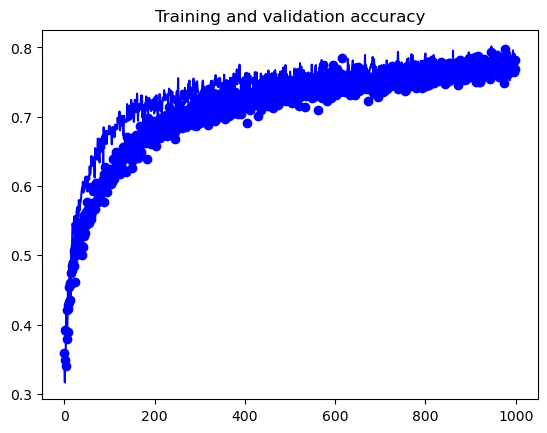

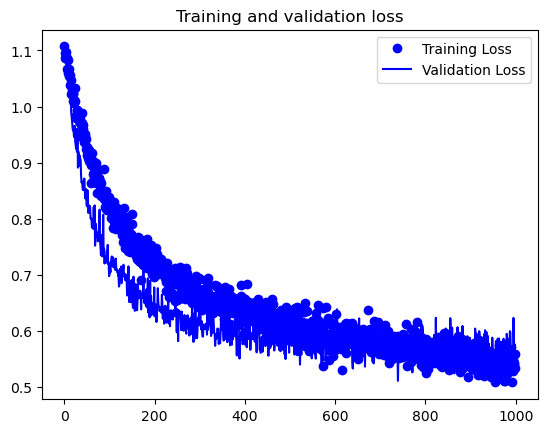

In [7]:
# Plot of the history of loss and accuracy during the epochs

plot_loss_acc(history)

In [43]:
# 3 - all - 300
# Compile our model and fit with our train dataset

# Compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit
history = model.fit(train_generator,
                    steps_per_epoch=56,
                    epochs = 300,
                    validation_data=test_generator,
                    validation_steps = 56)

Epoch 1/300
56/56 [==============================] - 10s 162ms/step - loss: 1.0738 - accuracy: 0.4621 - val_loss: 1.0399 - val_accuracy: 0.4475
Epoch 2/300
56/56 [==============================] - 9s 156ms/step - loss: 1.0309 - accuracy: 0.4609 - val_loss: 1.0276 - val_accuracy: 0.4643
Epoch 3/300
56/56 [==============================] - 9s 156ms/step - loss: 1.0185 - accuracy: 0.4542 - val_loss: 1.0180 - val_accuracy: 0.4693
Epoch 4/300
56/56 [==============================] - 9s 157ms/step - loss: 1.0135 - accuracy: 0.4872 - val_loss: 1.0086 - val_accuracy: 0.4593
Epoch 5/300
56/56 [==============================] - 9s 160ms/step - loss: 1.0206 - accuracy: 0.4503 - val_loss: 1.0112 - val_accuracy: 0.4609
Epoch 6/300
56/56 [==============================] - 10s 170ms/step - loss: 1.0206 - accuracy: 0.4598 - val_loss: 1.0173 - val_accuracy: 0.4554
Epoch 7/300
56/56 [==============================] - 9s 165ms/step - loss: 1.0094 - accuracy: 0.4715 - val_loss: 0.9902 - val_accuracy: 0.49

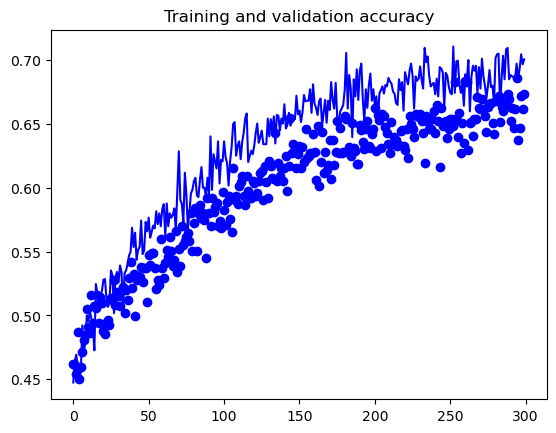

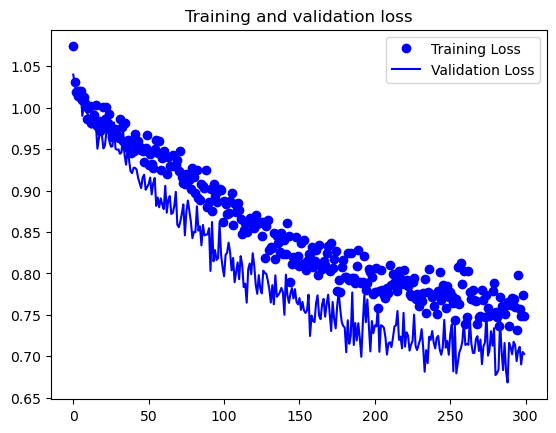

In [46]:
# Plot of the history of loss and accuracy during the epochs

plot_loss_acc(history)

In [140]:
# 7 - 300
# Compile our model and fit with our train dataset

# Compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit
history = model.fit(train_generator,
                    steps_per_epoch=56,
                    epochs = 200,
                    validation_data=test_generator,
                    validation_steps = 56)

Epoch 1/200
56/56 [==============================] - 10s 160ms/step - loss: 1.0349 - accuracy: 0.4526 - val_loss: 1.0250 - val_accuracy: 0.4671
Epoch 2/200
56/56 [==============================] - 9s 155ms/step - loss: 1.0379 - accuracy: 0.4369 - val_loss: 1.0335 - val_accuracy: 0.4068
Epoch 3/200
56/56 [==============================] - 9s 152ms/step - loss: 1.0234 - accuracy: 0.4587 - val_loss: 1.0006 - val_accuracy: 0.4604
Epoch 4/200
56/56 [==============================] - 9s 154ms/step - loss: 1.0097 - accuracy: 0.4721 - val_loss: 1.0125 - val_accuracy: 0.4498
Epoch 5/200
56/56 [==============================] - 9s 161ms/step - loss: 1.0159 - accuracy: 0.4715 - val_loss: 0.9911 - val_accuracy: 0.4894
Epoch 6/200
56/56 [==============================] - 9s 159ms/step - loss: 1.0113 - accuracy: 0.4805 - val_loss: 0.9989 - val_accuracy: 0.4766
Epoch 7/200
56/56 [==============================] - 9s 159ms/step - loss: 1.0202 - accuracy: 0.4643 - val_loss: 1.0102 - val_accuracy: 0.497

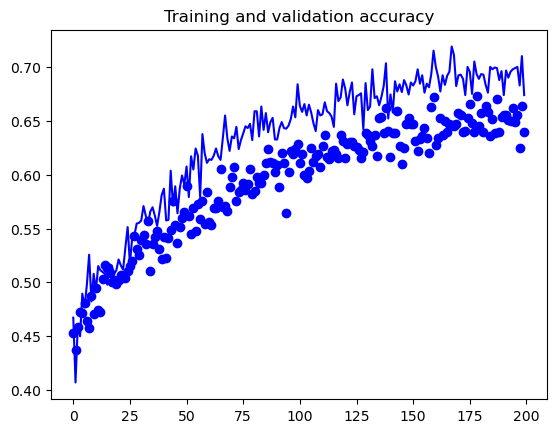

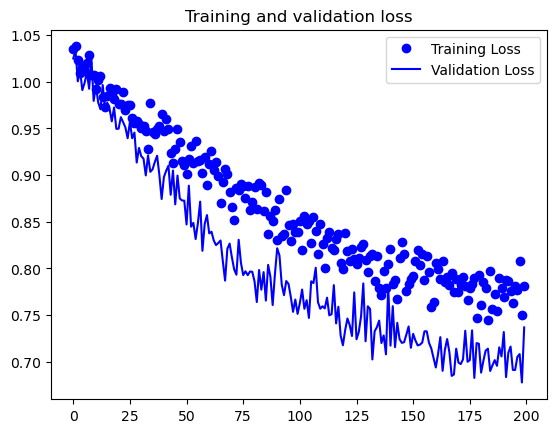

In [141]:
# Plot of the history of loss and accuracy during the epochs

plot_loss_acc(history)

In [8]:
# Save our model

#model.save('Model_3_soft_1000.h5')

In [26]:
# Load our model

model=load_model('Model_3_soft.h5')

In [27]:
model.evaluate(test_generator)

95/95 [==============================] - 5s 44ms/step - loss: 0.6151 - accuracy: 0.7354


[0.6150833368301392, 0.7354111671447754]

In [3]:
# Function to predict the emotion of an image

def three_emotions(img_path, model):

    l_emotions = ["negative", "neutral", "positive"]

    # Take the image
    img_1 = Image.open(img_path)

    # Normalization
    img = np.asarray(img_1)/255.0

    # Resize
    img = cv2.resize(img, (48, 48))
    img = np.expand_dims(img, axis=0)

    # Prediction of the image

    predictions = model.predict(np.array(img))

    emotion_predictions = zip(l_emotions, predictions[0])
    sorted_predictions = sorted(emotion_predictions, key=lambda x: x[1], reverse=True)

    # Print the predictions and return the image
    for emotion, prediction in sorted_predictions:
        percentage = round(prediction * 100, 2)
        print(emotion, ":", f"{prediction:.2%}")

    return img_1

1/1 [==============================] - 0s 170ms/step
positive : 62.21%
negative : 32.85%
neutral : 4.94%


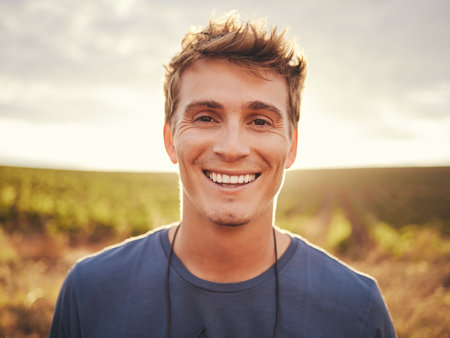

In [4]:
# Image 1

three_emotions('happy.jpg', model)

1/1 [==============================] - 0s 27ms/step
negative : 46.90%
positive : 35.06%
neutral : 18.04%


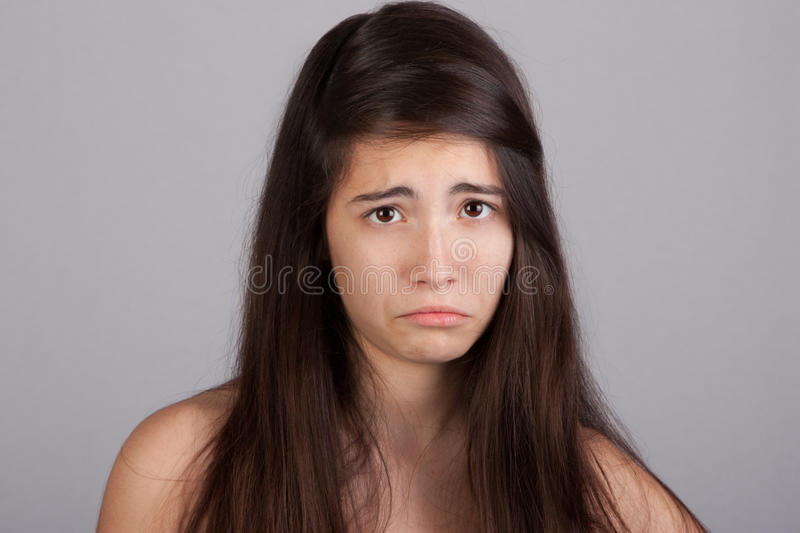

In [146]:
# Image 2

three_emotions('sad.jpg', model)

In [ ]:
# Image 3

three_emotions('julien_happy.jpg', model)

In [ ]:
# Image 4

three_emotions('gab_happy.jpg', model)

In [ ]:
# Image 5

three_emotions('noah_angry.jpg', model)

In [ ]:
# Image 6

three_emotions('julien_neutre.jpg', model)

In [1]:
import cv2
import tensorflow as tf
import numpy as np
import time

# Charger le modèle
model = tf.keras.models.load_model('Model_3_soft.h5')

# Charger le détecteur de visage Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0) # Utiliser la première caméra connectée
delay = 1  # Délai en secondes entre chaque capture

# Libellés d'émotions
l_emotions = ["negative", "neutral", "positive"]

# Couleurs pour chaque émotion
emotion_colors = [(0, 0, 255), (0, 255, 255), (0, 255, 0)]

# Compteur d'émotions
emotion_count = [0, 0, 0]

def detect_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 1:
        (x, y, w, h) = faces[0]
        face_img = img[y:y+h, x:x+w]
        return (face_img, (x, y, w, h))
    else:
        return (None, None)


def predict_emotion(img):
    # Ajoutez ici le prétraitement de l'image nécessaire pour votre modèle
    img = cv2.resize(img, (48, 48))  # Redimensionner l'image pour votre modèle
    img = img / 255.0  # Normaliser les pixels si votre modèle s'attend à cela
    img = np.expand_dims(img, axis=0)  # Ajouter une dimension supplémentaire si votre modèle s'attend à cela
    prediction = model.predict(img, verbose=0)
    return np.argmax(prediction)  # Retourne l'index de l'émotion prédite

# Compteur pour le nombre de captures
capture_count = 0

# Variables pour la prédiction toutes les secondes
prediction_timer = time.time()
prediction_interval = 1

# Variable pour l'affichage de l'émotion chaque seconde
emotion_display_timer = time.time()
emotion_display_interval = 1

while True:
    # Stopper la boucle après 10 captures
    if capture_count >= 10:
        break

    # Capturer une image de la caméra
    ret, frame = cap.read()

    if not ret:
        break

    # Détecter le visage dans l'image
    face_img, face_coords = detect_face(frame)

    if face_img is not None:
        # Dessiner un carré autour du visage détecté et afficher l'émotion
        (x, y, w, h) = face_coords
        emotion = predict_emotion(face_img)
        emotion_count[emotion] += 1

        # Colorer le carré selon l'émotion détectée
        color = emotion_colors[emotion]
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)

        # Afficher le label de l'émotion au-dessus du carré
        text = l_emotions[emotion]
        cv2.putText(frame, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        # Vérifier si une seconde s'est écoulée pour effectuer une prédiction
        if time.time() - prediction_timer >= prediction_interval:
            prediction_timer = time.time()

        # Afficher l'émotion chaque seconde
        if time.time() - emotion_display_timer >= emotion_display_interval:
            print(f"Emotion: {l_emotions[emotion]}")
            emotion_display_timer = time.time()

    else:
        # Afficher un message si aucun visage n'est détecté
        cv2.putText(frame, "No face detected", (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # Afficher l'image à l'écran
    cv2.imshow('Webcam', frame)

    # Si l'utilisateur appuie sur 'q', quitter la boucle
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Pause entre deux images
    time.sleep(delay)

# Afficher les pourcentages après les 10 captures
total = sum(emotion_count)
percentages = [count / total * 100 for count in emotion_count]
for i in range(3):
    print(f'Percentage of {l_emotions[i]}: {percentages[i]:.2f}%')

# Libérer les ressources et fermer les fenêtres
cap.release()
cv2.destroyAllWindows()


Emotion: negative
Emotion: neutral
Emotion: negative
Emotion: neutral
Emotion: negative
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: positive
Emotion: positive
Emotion: positive
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: neutral
Emotion: positive
Emotion: neutral
Emotion: neutral
Emotion